In [ ]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-36tewrfv
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-36tewrfv
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [311]:
%%cuda --name matmul.cu
#include <cstdlib>
#include <curand.h>
#include <cublas_v2.h>
#include <iostream>
#include <ctime>


using namespace std;


#define BLOCK_SIZE 32


__global__ void matMulKernel(const double *A, const double *B, double *C, const int N) {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;

    if (row < N && col < N) {
        for (int i = 0; i < N; i++) {
            C[row * N + col] += A[row * N + i] * B[i * N + col];
        }
    }
}

#define kernel matMulKernel


// Fill the array A(nr_rows_A, nr_cols_A) with random numbers on GPU
void GPU_fill_rand(double *A, int nr_rows_A, int nr_cols_A) {
    // Create a pseudo-random number generator
    curandGenerator_t prng;
    curandCreateGenerator(&prng, CURAND_RNG_PSEUDO_DEFAULT);
    // Set the seed for the random number generator using the system clock
    curandSetPseudoRandomGeneratorSeed(prng, (unsigned long long) clock());

    // Fill the array with random numbers on the device
    curandGenerateUniformDouble(prng, A, nr_rows_A * nr_cols_A);
}

// Multiply the arrays A and B on GPU and save the result in C
// C(m,n) = A(m,k) * B(k,n)
void gpu_blas_mmul(const double *A, const double *B, double *C, const int m, const int k, const int n) {
    int lda=m,ldb=k,ldc=m;
    const double alf = 1;
    const double bet = 0;
    const double *alpha = &alf;
    const double *beta = &bet;
    // Create a handle for CUBLAS
    cublasHandle_t handle;
    cublasCreate(&handle);
    // Do the actual multiplication
    // I switch the parameters A and B to be handled has column major
    cublasDgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N, m, n, k, alpha, B, ldb, A, lda, beta, C, ldc);
    // Destroy the handle
    cublasDestroy(handle);
}

void cpu_mmul(const double *A, const double *B, double *C, const int N) {
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            C[i * N + j] = 0.0;
            for (int k = 0; k < N; ++k)
                C[i * N + j] += A[i * N + k] * B[k * N + j];
        }
    }
}

void print_matrix_forward(const double *matrix, const int &rows, const int &cols) {
	for(int i = 0; i < rows; ++i){
		for(int j = 0; j < cols; ++j){
			printf("%f ", matrix[i * rows + j]);
		}
		printf("\n");
	}
	printf("\n");
}

void print_matrix_backward(const double *matrix, const int &rows, const int &cols, const int &n) {
	for(int i = rows - n; i < rows; ++i){
		for(int j = cols - n; j < cols; ++j){
			printf("%f ", matrix[i * rows + j]);
		}
		printf("\n");
	}
	printf("\n");
}

int main(int argc, char* argv[]) {
    int N = atoi(argv[1]);

    // Allocate 3 arrays on CPU
    int nr_rows_A, nr_cols_A, nr_rows_B, nr_cols_B, nr_rows_C, nr_cols_C;
    double start, end, cpu_time;
    double gpu_time;
    // float gpu_time;
    cudaError_t cuerr;

    // for simplicity we are going to use square arrays
    nr_rows_A = N;
    nr_cols_A = N;
    nr_rows_B = N;
    nr_cols_B = N;
    nr_rows_C = N;
    nr_cols_C = N;
    double *h_A = (double *)malloc(nr_rows_A * nr_cols_A * sizeof(double));
    double *h_B = (double *)malloc(nr_rows_B * nr_cols_B * sizeof(double));
    double *h_C = (double *)malloc(nr_rows_C * nr_cols_C * sizeof(double));

    // Allocate 3 arrays on GPU
    double *d_A, *d_B, *d_C;
    cudaMalloc(&d_A,nr_rows_A * nr_cols_A * sizeof(double));
    cudaMalloc(&d_B,nr_rows_B * nr_cols_B * sizeof(double));
    cudaMalloc(&d_C,nr_rows_C * nr_cols_C * sizeof(double));

    // Fill the arrays A and B on GPU with random numbers
    GPU_fill_rand(d_A, nr_rows_A, nr_cols_A);
    GPU_fill_rand(d_B, nr_rows_B, nr_cols_B);

    // Optionally we can copy the data back on CPU and print the arrays
    cudaMemcpy(h_A,d_A,nr_rows_A * nr_cols_A * sizeof(double),cudaMemcpyDeviceToHost);
    cudaMemcpy(h_B,d_B,nr_rows_B * nr_cols_B * sizeof(double),cudaMemcpyDeviceToHost);
    cout << "A =" << endl;
    print_matrix_forward(h_A, 5, 5);
    cout << "B =" << endl;
    print_matrix_forward(h_B, 5, 5);

    // Multiply A and B on GPU (library version)
    // start = clock();
    // gpu_blas_mmul(d_A, d_B, d_C, nr_rows_A, nr_cols_A, nr_cols_B);
    // end = clock();
    // gpu_time = (end - start) / CLOCKS_PER_SEC;

    dim3 threadsPerBlock(BLOCK_SIZE, BLOCK_SIZE);
    int GRID_SIZE = (N + BLOCK_SIZE - 1) / BLOCK_SIZE;
    dim3 blocksPerGrid(GRID_SIZE, GRID_SIZE);
    cout << "GRID_SIZE: (" << blocksPerGrid.x << ", " << blocksPerGrid.y << ", " << blocksPerGrid.z << ')' << endl;
    cout << "BLOCK_SIZE: (" << threadsPerBlock.x << ", " << threadsPerBlock.y << ", " << threadsPerBlock.z << ')' << endl;

    // Multiply A and B on GPU (kernel version)
    //cudaEvent_t start_ev, stop_ev;
    //cuerr = cudaEventCreate(&start_ev);
    //cuerr = cudaEventCreate(&stop_ev);
    //cudaEventRecord(start_ev, 0);
    start = clock();
    // run kernel
    kernel<<< blocksPerGrid, threadsPerBlock >>>(d_A, d_B, d_C, N);

    cuerr = cudaGetLastError();
    if (cuerr != cudaSuccess) {
        cout << "Cannot launch CUDA kernel: " << cudaGetErrorString(cuerr) << endl;
        return 0;
    }
    cuerr = cudaDeviceSynchronize();
    if (cuerr != cudaSuccess) {
        cout << "Cannot synchronize CUDA kernel: " << cudaGetErrorString(cuerr) << endl;
        return 0;
    }

    end=clock();
    gpu_time = (end - start) / CLOCKS_PER_SEC;
    //cuerr = cudaEventRecord(stop_ev, 0);
    //cudaEventElapsedTime(&gpu_time, start_ev, stop_ev);
    //gpu_time /= 1000;

    // Copy (and print) the result on host memory
    cuerr = cudaMemcpy(h_C, d_C, nr_rows_C * nr_cols_C * sizeof(double), cudaMemcpyDeviceToHost);
    if (cuerr != cudaSuccess) {
        cout << "Cannot copy a array from host to device: " << cudaGetErrorString(cuerr);
        return 0;
    }
    cout << "\nGPU C =" << endl;
    cout << "first 5x5" << endl;
    print_matrix_forward(h_C, 5, 5);
    cout << "last 5x5" << endl;
    print_matrix_backward(h_C, N, N, 5);

    double *cpu_C = (double *)malloc(nr_rows_C * nr_cols_C * sizeof(double));
    start = clock();
    cpu_mmul(h_A, h_B, cpu_C, N);
    end = clock();
    cpu_time = (end - start) / CLOCKS_PER_SEC;
    cout << "CPU C =" << endl;
    cout << "first 5x5" << endl;
    print_matrix_forward(cpu_C, 5, 5);
    cout << "last 5x5" << endl;
    print_matrix_backward(cpu_C, N, N, 5);

    double error = 0.0;
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            error += h_C[i * N + j] - cpu_C[i * N + j];
        }
    }

    cout << "\nError = " << error << endl;
    cout << "\nN = " << N << endl;
    cout << "\nGPU mul time = " << gpu_time << " seconds" << endl;
    cout << "\nCPU mul time = " << cpu_time  << " seconds" << endl;

    //cudaEventDestroy(start_ev);
    //cudaEventDestroy(stop_ev);

    //Free GPU memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    // Free CPU memory
    free(h_A);
    free(h_B);
    free(h_C);
    return 0;
}

'File written in /content/src/matmul.cu'

In [312]:
!nvcc -o /content/src/matmul /content/src/matmul.cu -lcurand -lcublas

In [324]:
!/content/src/matmul 2000

A =
0.189891 0.576693 0.429436 0.305648 0.888270 
0.377836 0.971365 0.476818 0.281939 0.461728 
0.893754 0.952376 0.487168 0.728830 0.656835 
0.887074 0.674655 0.150918 0.303853 0.625329 
0.408249 0.725911 0.523650 0.671044 0.665551 

B =
0.002657 0.496922 0.782056 0.428541 0.430971 
0.687939 0.910109 0.196968 0.639749 0.506687 
0.990028 0.133030 0.088243 0.819214 0.299985 
0.729200 0.443980 0.468774 0.629535 0.968312 
0.856006 0.489742 0.454841 0.972538 0.888841 

GRID_SIZE: (63, 63, 1)
BLOCK_SIZE: (32, 32, 1)

GPU C =
first 5x5
501.909161 497.816145 506.598166 499.367246 500.291108 
497.414917 491.646189 497.076312 495.096401 497.412563 
498.949937 499.824910 497.737051 487.212312 503.702518 
502.071941 500.767015 495.425259 484.456882 510.450254 
504.168241 503.943433 492.542246 487.918788 495.157709 

last 5x5
497.588543 491.706807 503.265698 504.961940 492.702062 
510.218915 507.952160 510.508246 522.017772 499.690213 
504.241565 493.843108 508.233109 506.890304 494.746554 
497.69

In [325]:
!pip install matplotlib

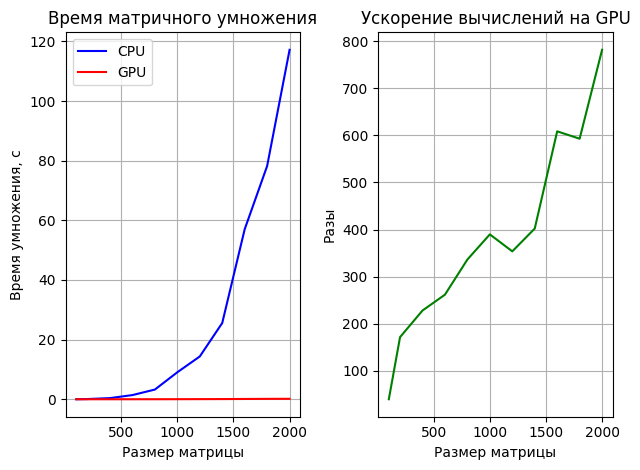

In [326]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
gpu_time = [0.000115, 0.000395, 0.001699, 0.00534, 0.00967, 0.02323, 0.04058, 0.06361, 0.09368, 0.13194, 0.14992]
cpu_time = [0.004551, 0.067737, 0.387365, 1.39737, 3.25237, 9.05389, 14.3532, 25.5743, 57.0130, 78.2295, 117.202]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Размер матрицы")
axes[0].set_ylabel("Время умножения, с")
axes[0].set_title('Время матричного умножения')

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Размер матрицы")
axes[1].set_ylabel("Разы")
axes[1].set_title('Ускорение вычислений на GPU')

plt.tight_layout()
plt.show()